# DR Binary CNN's On Train Subset

## Import the Data

In [1]:
# import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import ConfusionMatrixDisplay, classification_report

import tensorflow as tf
from keras_preprocessing.image import ImageDataGenerator
from tensorflow.keras import callbacks, initializers
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D
from keras import regularizers, optimizers, metrics

import cv2
from pathlib import Path

In [2]:
# upload csv files
# setting the dtype=str is to prevent an error that occurs later on if I don't

traindf=pd.read_csv("./diabetic-retinopathy-detection/Data/trainLabels.csv",dtype=str)
testdf=pd.read_csv("./diabetic-retinopathy-detection/Data/sampleSubmission.csv",dtype=str)

In [3]:
traindf.head()

,image,level
0,10_left,0
1,10_right,0
2,13_left,0
3,13_right,0
4,15_left,1


## Cleaning the Data

In [4]:
# creating a function that adds ".jpeg" to the image names
def append_ext(fn):
    return fn+".jpeg"

traindf["image"]=traindf["image"].apply(append_ext)
testdf["image"]=testdf["image"].apply(append_ext)

In [5]:
# checking to see if it worked
traindf.head()

,image,level
0,10_left.jpeg,0
1,10_right.jpeg,0
2,13_left.jpeg,0
3,13_right.jpeg,0
4,15_left.jpeg,1


### Change Target to Binary

In [6]:
traindf.level.replace({"2":"1", "3":"1", "4":"1"}, inplace=True)

In [7]:
# check work
traindf.level.value_counts()

0    25810
1     9316
Name: level, dtype: int64

In [8]:
# same thing as percentages
traindf.level.value_counts(normalize=True)

0    0.734783
1    0.265217
Name: level, dtype: float64

According to the training data, if one were to predict the majority class (not having DR), they would have a 73.5% accuracy score. A good goal would be to build a model that performs better than that dummy model. :)

## Model Process

Code is not run in order here.
* Variables are first assigned under the specific model name below located under the "Results" heading
* Then the code blocks under this heading are ran
* Then the graphs are plotted after each model

In [9]:
# image preprocessing
datagen=ImageDataGenerator(rescale=1./255.,
                           featurewise_center=True, #added in later
                           featurewise_std_normalization=True, #added in later
                           rotation_range=360,
                           zoom_range=0.05,
                           width_shift_range=0.05,
                           height_shift_range=0.05,
                           horizontal_flip=True,
                           vertical_flip=True,
                           brightness_range=[0.75,1.25],
                           validation_split=0.2)

In [11]:
# need to fit the generator on to the image list for the featurewise_std_normalization
datagen.fit(images)

In [33]:
# training subset generator (subset=training)
train_sub_generator=datagen.flow_from_dataframe(
dataframe=traindf,
directory="./diabetic-retinopathy-detection/Data/train_sub/", # data from smaller "subset" folder
x_col="image",
y_col="level",
subset="training",
batch_size=batches,
seed=42,
shuffle=True,
class_mode="binary",
target_size=size)


# validation subset generator (subset=validation)
valid_sub_generator=datagen.flow_from_dataframe(
dataframe=traindf,
directory="./diabetic-retinopathy-detection/Data/train_sub/", # data from smaller "subset" folder
x_col="image",
y_col="level",
subset="validation",
batch_size=batches,
seed=42,
shuffle=True,
class_mode="binary",
target_size=size)

/Users/jonniebrown/anaconda3/envs/learn-env/lib/python3.8/site-packages/keras_preprocessing/image/dataframe_iterator.py:279: UserWarning: Found 32626 invalid image filename(s) in x_col="image". These filename(s) will be ignored.
  warnings.warn(


Found 2000 validated image filenames belonging to 2 classes.
Found 500 validated image filenames belonging to 2 classes.


/Users/jonniebrown/anaconda3/envs/learn-env/lib/python3.8/site-packages/keras_preprocessing/image/dataframe_iterator.py:279: UserWarning: Found 32626 invalid image filename(s) in x_col="image". These filename(s) will be ignored.
  warnings.warn(


These warnings occur because the csv file has more images than my subset folder I created with 5,000 images.

In [34]:
model = Sequential()

model.add(Conv2D(64, (3, 3), activation=activation, padding = 'same', input_shape=shape))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(64, (3, 3), activation=activation, padding='same', input_shape=shape))
model.add(MaxPooling2D((2, 2)))

# model.add(Conv2D(128, (3, 3), activation=activation, input_shape=shape))
# model.add(Conv2D(128, (3, 3), activation=activation, input_shape=shape))
# model.add(MaxPooling2D((2, 2)))

In [35]:
model.add(Flatten())
# model.add(Dense(32, activation = activation, kernel_initializer=initializers.HeUniform()))
model.add(Dense(1, activation='sigmoid'))

In [36]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 256, 256, 64)      1792      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 128, 128, 64)     0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 128, 128, 64)      36928     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 64, 64, 64)       0         
 2D)                                                             
                                                                 
 flatten_2 (Flatten)         (None, 262144)            0         
                                                                 
 dense_2 (Dense)             (None, 1)                

In [37]:
model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy', 'Recall'])

In [38]:
early_stop = callbacks.EarlyStopping(monitor='val_loss',
                                     min_delta=1e-4,
                                     verbose=1,
                                     mode='min',
                                     patience=7)

In [39]:
results = model.fit(train_sub_generator,
                    validation_data = valid_sub_generator,
                    steps_per_epoch = train_sub_generator.n//train_sub_generator.batch_size,
                    validation_steps = valid_sub_generator.n//valid_sub_generator.batch_size,
                    epochs=50,
                    callbacks=early_stop,
                    class_weight=class_weight)

Epoch 1/50
62/62 [==============================] - 251s 4s/step - loss: 1.0566 - accuracy: 0.6484 - recall: 0.2122 - val_loss: 0.6903 - val_accuracy: 0.4625 - val_recall: 0.5802
Epoch 2/50
62/62 [==============================] - 247s 4s/step - loss: 0.6919 - accuracy: 0.6570 - recall: 0.2335 - val_loss: 0.6637 - val_accuracy: 0.6562 - val_recall: 0.1692
Epoch 3/50
62/62 [==============================] - 244s 4s/step - loss: 0.6833 - accuracy: 0.6601 - recall: 0.1950 - val_loss: 0.6792 - val_accuracy: 0.5792 - val_recall: 0.3817
Epoch 4/50
62/62 [==============================] - 246s 4s/step - loss: 0.6744 - accuracy: 0.7266 - recall: 0.0229 - val_loss: 0.6751 - val_accuracy: 0.7125 - val_recall: 0.0310
Epoch 5/50
62/62 [==============================] - 243s 4s/step - loss: 0.6761 - accuracy: 0.7068 - recall: 0.1458 - val_loss: 0.6608 - val_accuracy: 0.7063 - val_recall: 0.0620
Epoch 6/50
62/62 [==============================] - 242s 4s/step - loss: 0.6894 - accuracy: 0.7266 - reca

## Results

In [30]:
def plot_results(fit_model):
    # create lists to plot
    train_loss = fit_model.history['loss']
    train_acc = fit_model.history['accuracy']
    val_loss = fit_model.history['val_loss']
    val_acc = fit_model.history['val_accuracy']
    
    # the plot for the fit_model
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
    sns.lineplot(x=results.epoch, y=train_loss, ax=ax1, label='train_loss')
    sns.lineplot(x=results.epoch, y=train_acc, ax=ax2, label='train_accuracy')

    sns.lineplot(x=results.epoch, y=val_loss, ax=ax1, label='val_loss')
    sns.lineplot(x=results.epoch, y=val_acc, ax=ax2, label='val_accuracy');
    
    return None

### Model 1

In [9]:
# assign variables to easily try new variations
# Then run the code beginning under the heading "Model Process"
# Then run the code block underneath this one to plot the results
size = (32,32)
shape = size + (3,)
batches = 32
activation = "relu"
optimizer = "adam"

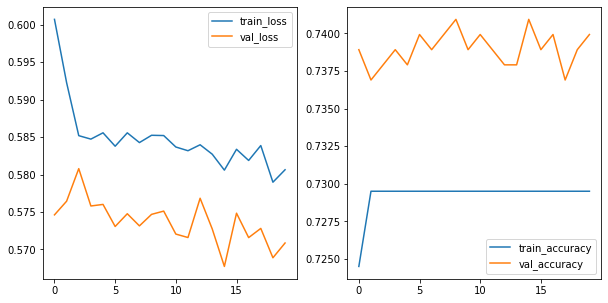

In [18]:
plot_results(results)

Both the train loss and the validation loss have a steady decline. It's interesting to note that the validation data did better than the training data. And it did not take long for the train accuracy to plateau.

### Model 2

In [19]:
# assign variables to easily try new variations
# Then run the code beginning under the heading "Model Process"
# Then run the code block underneath this one to plot the results
size = (128,128)
shape = size + (3,)
batches = 32
activation = "relu"
optimizer = "adam"

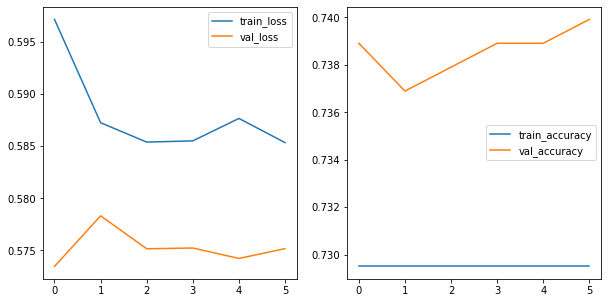

In [28]:
plot_results(results)

It looks like increasing the picture size did not decrease the loss or improve the accuracy significantly. There's a clearer picture of the validation loss decreasing with the smaller picture size. It's difficult to tell because it didn't run as many epochs. 

### Model 3

In [29]:
# assign variables to easily try new variations
# Then run the code beginning under the heading "Model Process"
# Then run the code block underneath this one to plot the results
size = (32,32)
shape = size + (3,)
batches = 32
activation = "tanh"
optimizer = "adam"

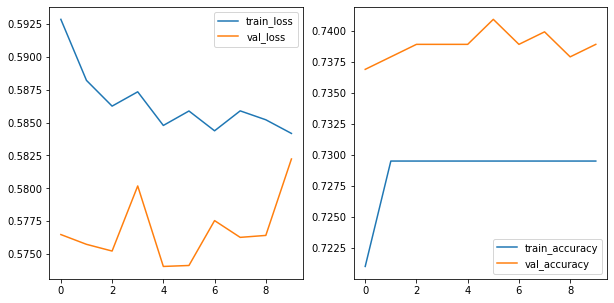

In [44]:
plot_results(results)

The tanh activation gave the validation loss very inconsistent results.

### Model 4

In [45]:
# assign variables to easily try new variations
# Then run the code beginning under the heading "Model Process"
# Then run the code block underneath this one to plot the results
size = (32,32)
shape = size + (3,)
batches = 32
activation = "swish"
optimizer = "adam"

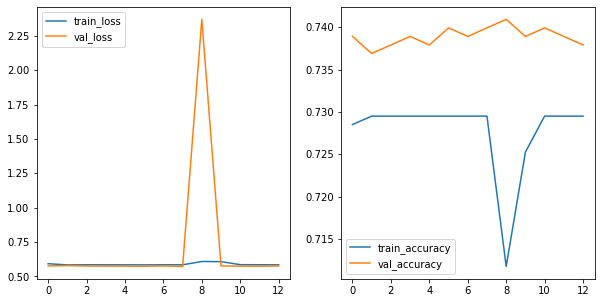

In [54]:
plot_results(results)

The swish activation gave a random spike, but mostly plateaued. 

### Model 5

In [55]:
# assign variables to easily try new variations
# Then run the code beginning under the heading "Model Process"
# Then run the code block underneath this one to plot the results
size = (32,32)
shape = size + (3,)
batches = 32
activation = ["relu","swish"]
optimizer = "adam"

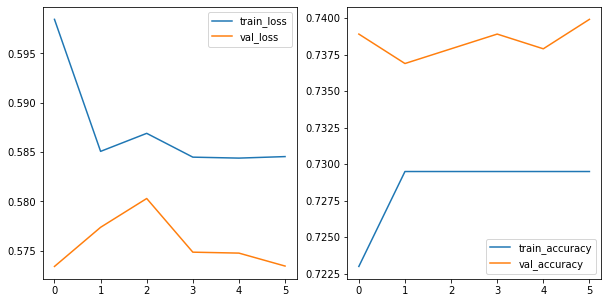

In [64]:
plot_results(results)

The combination of relu and swish activation functions did not seem to help much.  

### Model 6

In [65]:
# assign variables to easily try new variations
# Then run the code beginning under the heading "Model Process"
# Then run the code block underneath this one to plot the results
size = (32,32)
shape = size + (3,)
batches = 32
activation = "relu"
optimizer = "RMSProp"

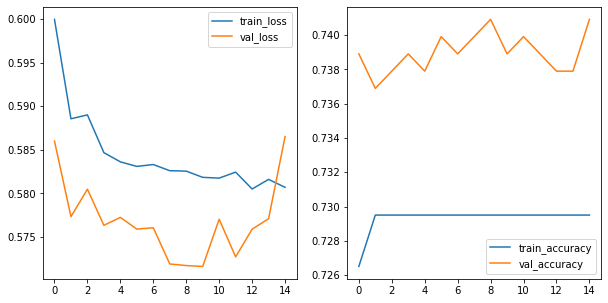

In [74]:
plot_results(results)

Changing the optimizer to RMSProp looked pretty good until the end. The validation loss started to shoot up.

### Model 7

In [75]:
# assign variables to easily try new variations
# Then run the code beginning under the heading "Model Process"
# Then run the code block underneath this one to plot the results
size = (32,32)
shape = size + (3,)
batches = 64 # changed from 32
activation = "relu"
optimizer = "adam"

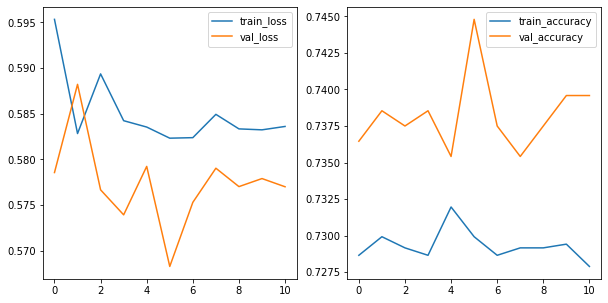

In [84]:
plot_results(results)

Changing the batch size to 64 gave inconsistent results. 

### Model 8

In [85]:
# assign variables to easily try new variations
# Then run the code beginning under the heading "Model Process"
# Then run the code block underneath this one to plot the results
size = (32,32)
shape = size + (3,)
batches = 32
activation = "relu"
optimizer = "adam"
# remove dense layer

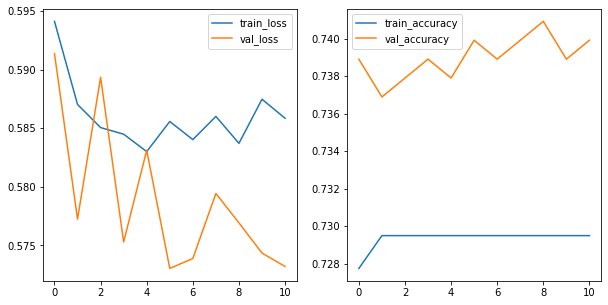

In [94]:
plot_results(results)

Taking away a dense layer gave a general pattern of decline for the validation loss. I would prefer it to be smoother. 

### Model 9

In [95]:
# assign variables to easily try new variations
# Then run the code beginning under the heading "Model Process"
# Then run the code block underneath this one to plot the results
size = (32,32)
shape = size + (3,)
batches = 32
activation = "relu"
optimizer = "adam"
# additional dense layer

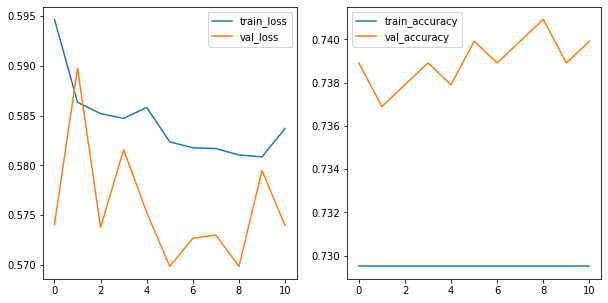

In [104]:
plot_results(results)

Adding an additional dense layer did not help with the train accuracy plateau.

### Model 10

In [108]:
# assign variables to easily try new variations
# Then run the code beginning under the heading "Model Process"
# Then run the code block underneath this one to plot the results
size = (32,32)
shape = size + (3,)
batches = 32
activation = "relu"
optimizer = optimizers.SGD(learning_rate=0.01)

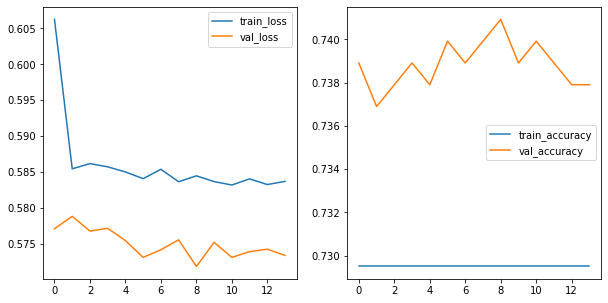

In [117]:
plot_results(results)

Changing optimizers to Stochastic Gradient Descent did not help much either. In order to break this plateau, I need to account for the class imbalance by implementing a class weight.

### Model 11

In [21]:
# assign variables to easily try new variations
# Then run the code beginning under the heading "Model Process"
# Then run the code block underneath this one to plot the results
size = (32,32)
shape = size + (3,)
batches = 32
activation = "relu"
optimizer = "adam"
# adding class weights

neg, pos = np.bincount(traindf.level)
total = neg + pos

# Scaling by total/2 helps keep the loss to a similar magnitude.
# The sum of the weights of all examples stays the same.
weight_for_0 = (1 / neg) * (total / 2.0)
weight_for_1 = (1 / pos) * (total / 2.0)

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 0.68
Weight for class 1: 1.89


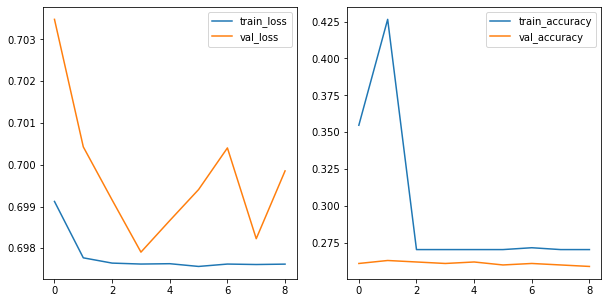

In [130]:
plot_results(results)

That changed some things. My average loss scores are very high and my accuracy scores are very low. But I can be confident that the model is guessing more than just the majority class. I want to try finding the right learning rate now.

### Model 12

In [157]:
# assign variables to easily try new variations
# Then run the code beginning under the heading "Model Process"
# Then run the code block underneath this one to plot the results
size = (32,32)
shape = size + (3,)
batches = 32
activation = "relu"
optimizer = optimizers.Adam(learning_rate=1e-5)
# with class weights

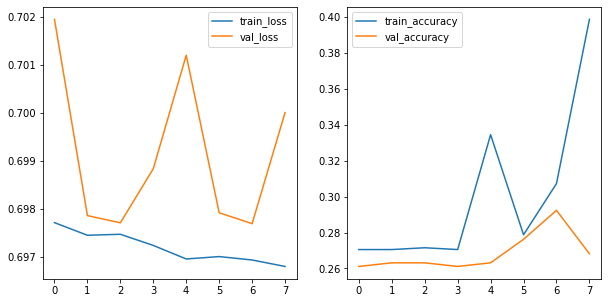

In [141]:
plot_results(results)

The validation loss seems to be inconsistent. I'm curious to see if increasing the patience level and adding more epochs would help. Let me try some other learning rates first.

### Model 13

In [142]:
# assign variables to easily try new variations
# Then run the code beginning under the heading "Model Process"
# Then run the code block underneath this one to plot the results
size = (32,32)
shape = size + (3,)
batches = 32
activation = "relu"
optimizer = optimizers.Adam(learning_rate=1e-4)
# with class weights

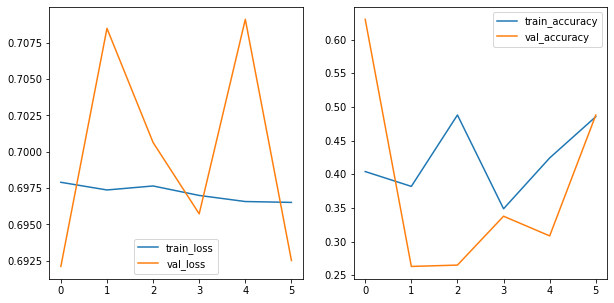

In [146]:
plot_results(results)

This one did not get very far at all. And the validation loss is very inconsistent.

### Model 14

In [147]:
# assign variables to easily try new variations
# Then run the code beginning under the heading "Model Process"
# Then run the code block underneath this one to plot the results
size = (32,32)
shape = size + (3,)
batches = 32
activation = "relu"
optimizer = optimizers.Adam(learning_rate=1e-3)
# with class weights

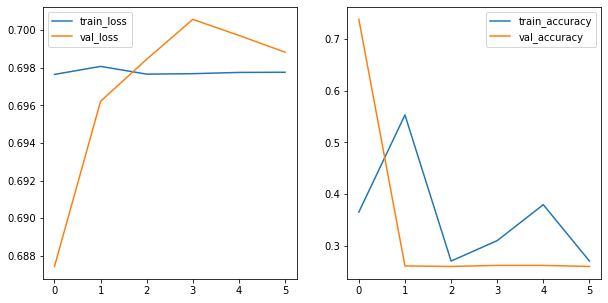

In [151]:
plot_results(results)

This one did not do well. The validation loss shot up instead of going down. And there weren't many epochs either. 

### Model 15

In [152]:
# assign variables to easily try new variations
# Then run the code beginning under the heading "Model Process"
# Then run the code block underneath this one to plot the results
size = (32,32)
shape = size + (3,)
batches = 32
activation = "relu"
optimizer = optimizers.Adam(learning_rate=1e-6)
# with class weights

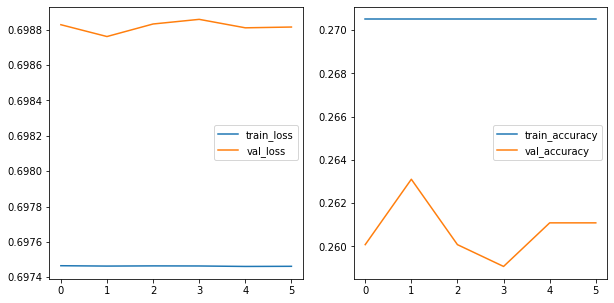

In [156]:
plot_results(results)

There aren't a whole lot of adjustments that were made on this one. I think the learning rate was a bit too slow.

### Model 16

In [29]:
# assign variables to easily try new variations
# Then run the code beginning under the heading "Model Process"
# Then run the code block underneath this one to plot the results
size = (32,32)
shape = size + (3,)
batches = 32
activation = "relu"
optimizer = optimizers.Adam(learning_rate=1e-5)
# with class weights
# increasing patience level from 5 to 10 to get more epochs...

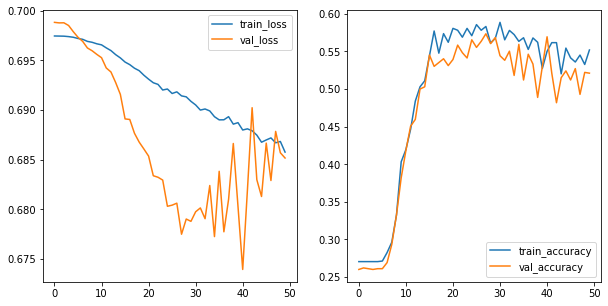

In [161]:
plot_results(results)

This is the first model that looks like something to work with. The losses go down and the accuracies go up. The accuracies aren't as high as I would like them. I'm going to try to simplify the model by removing some hidden layers. This might help to increase the accuracy score. 

### Model 17

In [168]:
# assign variables to easily try new variations
# Then run the code beginning under the heading "Model Process"
# Then run the code block underneath this one to plot the results
size = (32,32)
shape = size + (3,)
batches = 32
activation = "relu"
optimizer = optimizers.Adam(learning_rate=1e-6)
# with class weights
# increasing patience level from 5 to 7 to get more epochs...
# change layer structure by removing last 3 layers before flattening.

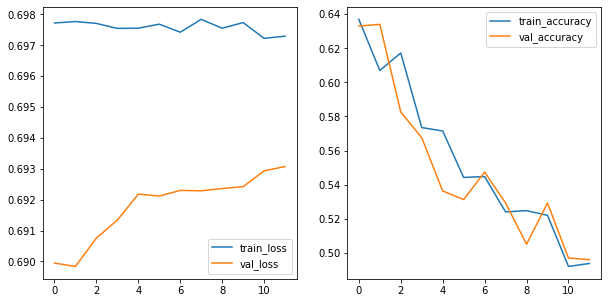

In [177]:
plot_results(results)

The accuracies are going down, which is not what I want to see. I may need to readjust my learning rate. But the accuracy scores are higher than the previous model.

### Model 18

In [191]:
# assign variables to easily try new variations
# Then run the code beginning under the heading "Model Process"
# Then run the code block underneath this one to plot the results
size = (32,32)
shape = size + (3,)
batches = 32
activation = "relu"
optimizer = optimizers.Adam(learning_rate=1e-5)
# with class weights
# increasing patience level from 5 to 7 to get more epochs...
# change layer structure completely alternating conv2d and maxpool total 5. 

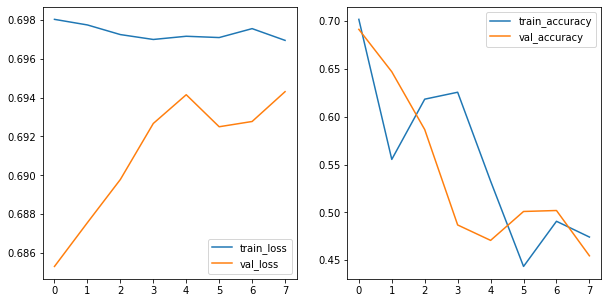

In [200]:
plot_results(results)

This isn't much better than the last model. The validation loss goes up. I wonder if slowing the learning rate will make a difference. 

### Model 19

In [208]:
# assign variables to easily try new variations
# Then run the code beginning under the heading "Model Process"
# Then run the code block underneath this one to plot the results
size = (32,32)
shape = size + (3,)
batches = 32
activation = "relu"
optimizer = optimizers.Adam(learning_rate=1e-7)
# with class weights
# increasing patience level from 5 to 7 to get more epochs...
# change layer structure completely alternating conv2d and maxpool total 5. 

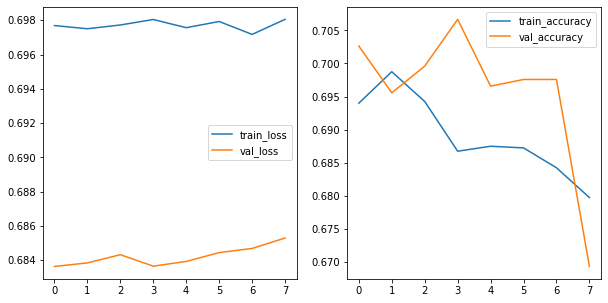

In [215]:
plot_results(results)

This is a little bit better, but it's not great. I'm going to try slowing the learning rate even more.

### Model 20

In [216]:
# assign variables to easily try new variations
# Then run the code beginning under the heading "Model Process"
# Then run the code block underneath this one to plot the results
size = (32,32)
shape = size + (3,)
batches = 32
activation = "relu"
optimizer = optimizers.Adam(learning_rate=1e-8)
# with class weights
# increasing patience level from 5 to 7 to get more epochs...
# change layer structure completely alternating conv2d and maxpool total 5. 

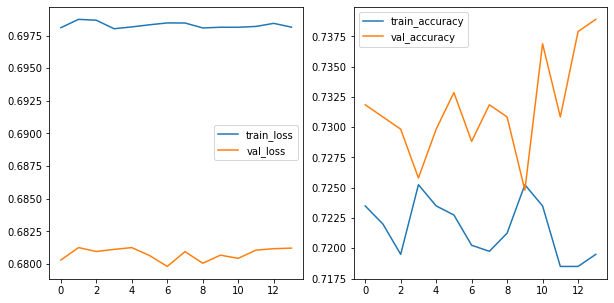

In [234]:
plot_results(results)

I'm pretty sure this is just guessing the majority class, and the learning rate is so small that it's not actually learning. I'm going to try standardizing the data with the ImageDataGenerator's featurewise_std_normalization to see if that improves things.

### Model 21

In [10]:
# making a list of images to fit the ImageDataGenerator on
# I want to use a subset so as to prevent too much data leakage
path=Path("./diabetic-retinopathy-detection/Data/train_sub")

path=path.glob("*.jpeg")

images=[]


for imagepath in path:

        img=cv2.imread(str(imagepath))                       
        img=cv2.resize(img,(32,32)) # same size as generators
        images.append(img)

In [255]:
# assign variables to easily try new variations
# Then run the code beginning under the heading "Model Process"
# Then run the code block underneath this one to plot the results
size = (32,32)
shape = size + (3,)
batches = 32
activation = "relu"
optimizer = optimizers.Adam(learning_rate=1e-5)
# with class weights
# increasing patience level from 5 to 7 to get more epochs...
# change layer structure completely alternating conv2d and maxpool total 5. 
# adding featurewise_std_normalization to imagedatagenerator

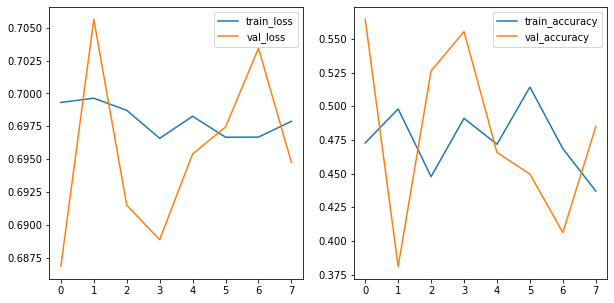

In [268]:
plot_results(results)

The validation data is a bit all over the place. I'm going to try adjusting the learning rate and the layer structure.

### Model 22

In [279]:
# assign variables to easily try new variations
# Then run the code beginning under the heading "Model Process"
# Then run the code block underneath this one to plot the results
size = (32,32)
shape = size + (3,)
batches = 32
activation = "relu"
optimizer = optimizers.Adam(learning_rate=1e-4)
# with class weights
# increasing patience level from 5 to 7 to get more epochs...
# change layer structure by removing last 3 layers before flattening.
# adding featurewise_std_normalization to imagedatagenerator

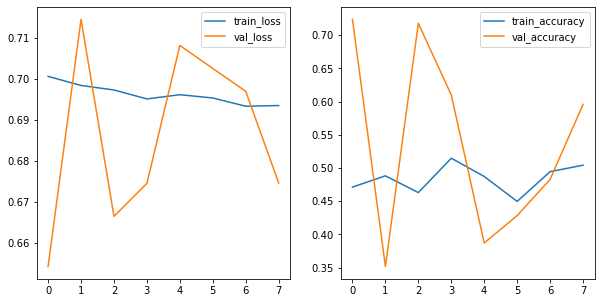

In [286]:
plot_results(results)

That didn't seem to help much. I'm going back to what I did with mdoel 16 but with the featurewise_std_normalization.

### Model 23

In [287]:
# assign variables to easily try new variations
# Then run the code beginning under the heading "Model Process"
# Then run the code block underneath this one to plot the results
size = (32,32)
shape = size + (3,)
batches = 32
activation = "relu"
optimizer = optimizers.Adam(learning_rate=1e-5)
# with class weights
# increasing patience level from 5 to 10 to get more epochs...
# adding featurewise_std_normalization to imagedatagenerator

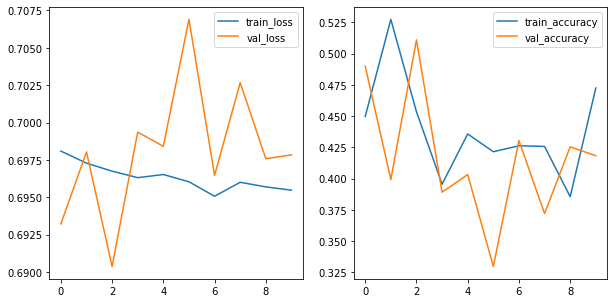

In [298]:
plot_results(results)

I'm going to try increasing the picture size and take away the featurewise_std_normalization to see if that does anything and add a clipvalue to see if that will smooth things out.

### Model 24

In [20]:
# assign variables to easily try new variations
# Then run the code beginning under the heading "Model Process"
# Then run the code block underneath this one to plot the results
size = (64,64)
shape = size + (3,)
batches = 32
activation = "relu"
optimizer = optimizers.Adam(learning_rate=1e-5, clipvalue=4.0)
# with class weights
# increasing patience level from 5 to 7 to get more epochs...

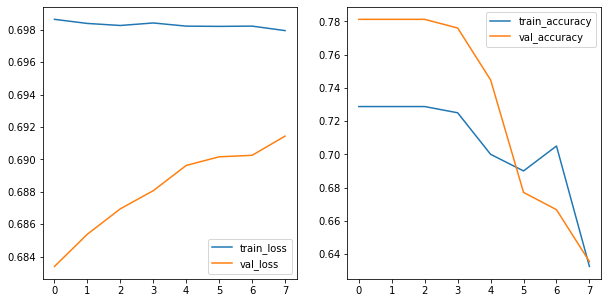

In [28]:
plot_results(results)

The lines are smooth, but they're going in the wrong direction.

### Model 25

In [38]:
# assign variables to easily try new variations
# Then run the code beginning under the heading "Model Process"
# Then run the code block underneath this one to plot the results
size = (128,128)
shape = size + (3,)
batches = 32
activation = "relu"
optimizer = optimizers.Adam()
# with class weights
# increasing patience level from 5 to 7 to get more epochs...

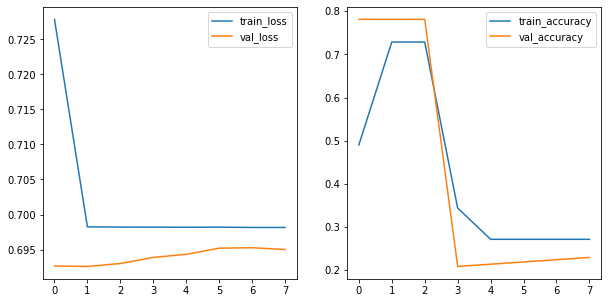

In [47]:
plot_results(results)

I'm going to reduce the model complexity by adjusting how many layers there are. 

### Model 26

In [ ]:
# assign variables to easily try new variations
# Then run the code beginning under the heading "Model Process"
# Then run the code block underneath this one to plot the results
size = (128,128)
shape = size + (3,)
batches = 32
activation = "relu"
optimizer = optimizers.Adam()
# with class weights
# increasing patience level from 5 to 7 to get more epochs...

#conv max conv max conv max

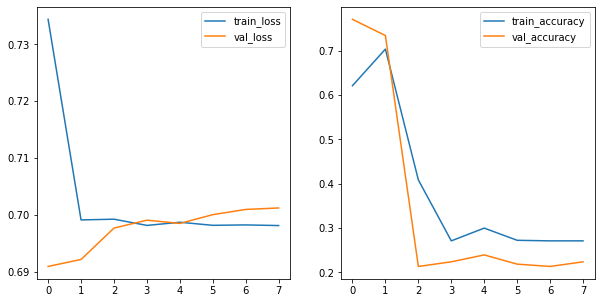

In [57]:
plot_results(results)

## I'm starting over
### Model 27
The first thing I need to do is settle on a layer structure for the model. I'm going to try
* Conv Max Conv Max
* Conv Max Conv Max Conv Max
* Conv Conv Max Conv Conv Max
* Conv Conv Max Conv Conv Max Conv Conv Max

In [10]:
# assign variables to easily try new variations
# Then run the code beginning under the heading "Model Process"
# Then run the code block underneath this one to plot the results
size = (256,256) # increasing the picture size
shape = size + (3,)
batches = 32
activation = "relu"
optimizer = optimizers.Adam()
# with class weights
# increasing patience level from 5 to 7 to get more epochs...

# conv max conv max

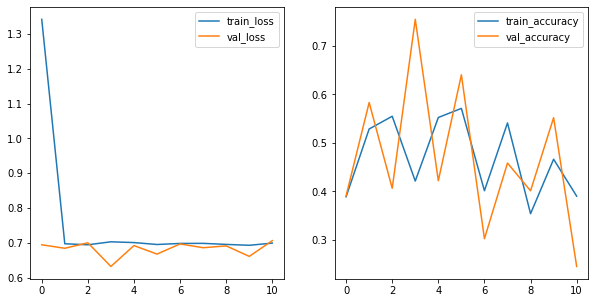

In [117]:
plot_results(results)

### Model 28

In [86]:
# assign variables to easily try new variations
# Then run the code beginning under the heading "Model Process"
# Then run the code block underneath this one to plot the results
size = (256,256)
shape = size + (3,)
batches = 32
activation = "relu"
optimizer = optimizers.Adam()
# with class weights
# increasing patience level from 5 to 7 to get more epochs...

# conv max conv max conv max

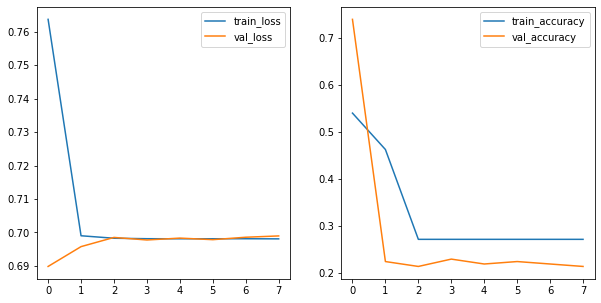

In [87]:
plot_results(results)

### Model 29

In [88]:
# assign variables to easily try new variations
# Then run the code beginning under the heading "Model Process"
# Then run the code block underneath this one to plot the results
size = (256,256)
shape = size + (3,)
batches = 32
activation = "relu"
optimizer = optimizers.Adam()
# with class weights
# increasing patience level from 5 to 7 to get more epochs...

# conv conv max conv conv max

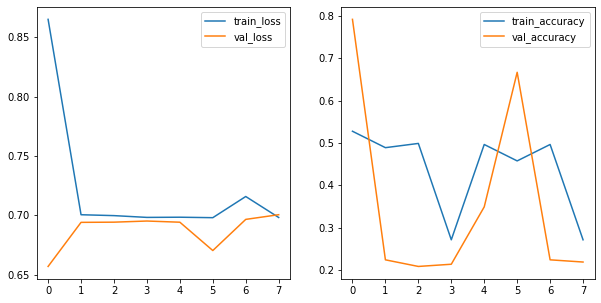

In [95]:
plot_results(results)

### Model 30

In [96]:
# assign variables to easily try new variations
# Then run the code beginning under the heading "Model Process"
# Then run the code block underneath this one to plot the results
size = (256,256)
shape = size + (3,)
batches = 32
activation = "relu"
optimizer = optimizers.Adam()
# with class weights
# increasing patience level from 5 to 7 to get more epochs...

# conv conv max conv conv max conv conv max

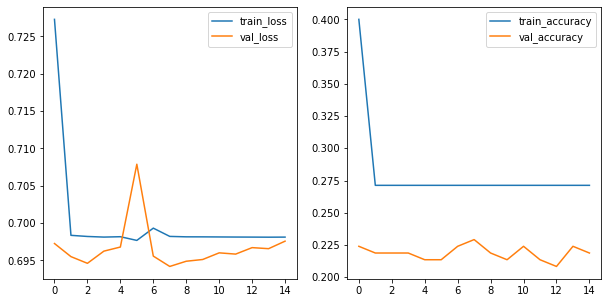

In [103]:
plot_results(results)

Out of these layer structures, I think the first one (model 27) has the most potential to work with because the accuracy scores have the most shape. So I'm going to start with a small number of neurons and work up from there.

### Model 31

In [30]:
# assign variables to easily try new variations
# Then run the code beginning under the heading "Model Process"
# Then run the code block underneath this one to plot the results
size = (256,256) # increasing the picture size
shape = size + (3,)
batches = 32
activation = "relu"
optimizer = optimizers.Adam()
# with class weights
# increasing patience level from 5 to 7 to get more epochs...

# conv32 max conv32 max

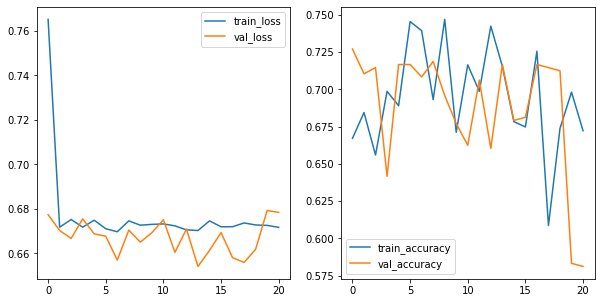

In [33]:
plot_results(results)

### Model 32

In [34]:
# assign variables to easily try new variations
# Then run the code beginning under the heading "Model Process"
# Then run the code block underneath this one to plot the results
size = (256,256) # increasing the picture size
shape = size + (3,)
batches = 32
activation = "relu"
optimizer = optimizers.Adam(learning_rate=1e-4)
# with class weights
# increasing patience level from 5 to 7 to get more epochs...

# conv128 max conv128 max

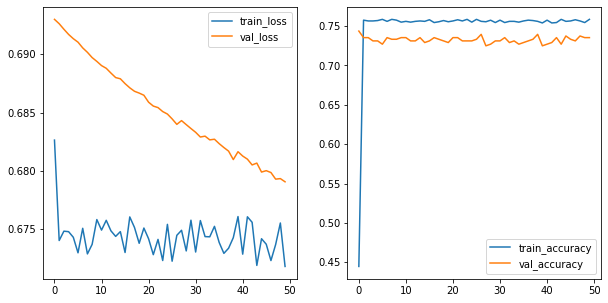

In [41]:
plot_results(results)

In [42]:
# This gives probabilities which is needed to get the y predictions
pred = model.predict(valid_sub_generator, steps = valid_sub_generator.n//valid_sub_generator.batch_size)

# The y predictions which is needed for the confusion matrix
y_pred = pred.argmax(axis=-1)

15/15 [==============================] - 45s 3s/step


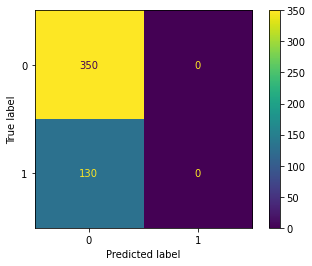

In [43]:
ConfusionMatrixDisplay.from_predictions(valid_sub_generator.classes[:len(y_pred)], y_pred)

It looks like I'm a little overfit and just predicting the majority class. I'm going to try simplifying the model even more by reducing the number of neurons.

### Model 33

In [87]:
# assign variables to easily try new variations
# Then run the code beginning under the heading "Model Process"
# Then run the code block underneath this one to plot the results
size = (256,256)
shape = size + (3,)
batches = 32
activation = "relu"
optimizer = optimizers.Adam(clipvalue=4.0)
# with class weights
# increasing patience level from 5 to 7 to get more epochs...

# conv64 max conv64 max

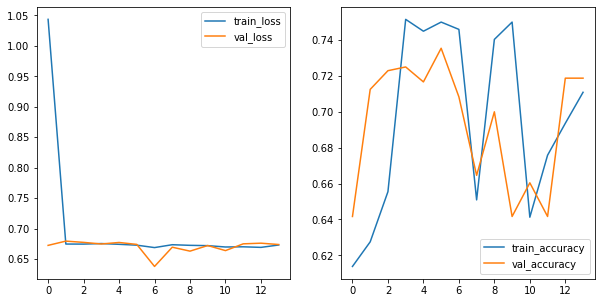

In [105]:
plot_results(results)

In [22]:
# assign variables to easily try new variations
# Then run the code beginning under the heading "Model Process"
# Then run the code block underneath this one to plot the results
size = (256,256) 
shape = size + (3,)
batches = 32
activation = "relu"
optimizer = optimizers.Adam(learning_rate=0.01, clipnorm=1.0)
# with class weights
# increasing patience level from 5 to 7 to get more epochs...

# conv64 max conv64 max

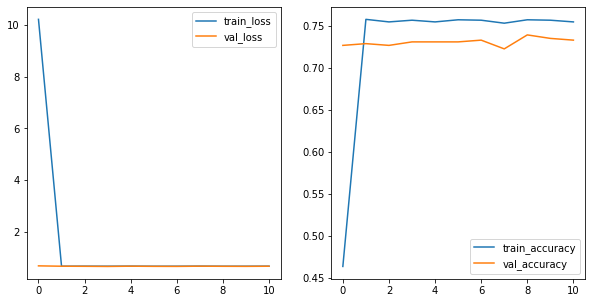

In [31]:
plot_results(results)

This model just predicted the majority class the whole time.

In [32]:
# assign variables to easily try new variations
# Then run the code beginning under the heading "Model Process"
# Then run the code block underneath this one to plot the results
size = (256,256) 
shape = size + (3,)
batches = 32
activation = "relu"
optimizer = optimizers.Adam(clipnorm=1.0)
# with class weights
# increasing patience level from 5 to 7 to get more epochs...

# conv64 max conv64 max

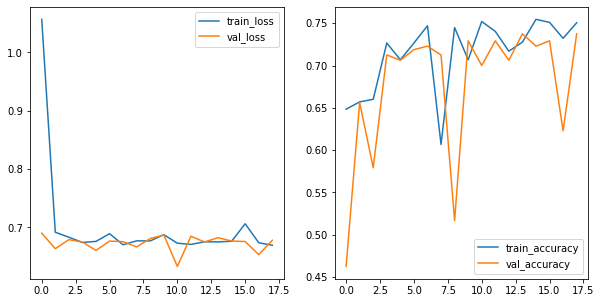

In [40]:
plot_results(results)